Structure:

- Get images
  - Per patient
  - Train
  - Test
-Run all images through feature detection
-Take each patient, run PCA with k =?
-Run MLP classifier / linear discriminator

# Imports and drive

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
#import kornia
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
import cv2

import re
import json 
import glob

from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA, KernelPCA

# %matplotlib notebook
%matplotlib inline

In [2]:
# Connect to drive to save work
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Proj_B
#!git clone https://github.com/mocedon/VISL_project
#!git pull
%cd VISL_project

Mounted at /content/gdrive
/content/gdrive/MyDrive/Proj_B
/content/gdrive/MyDrive/Proj_B/VISL_project


# Goofing around

In [ ]:
l1 = [1,2,3,4,5,6,7]
l2 = l1
l2 = [i for i in l2 if i%2 == 0]
print(l1)
print(l2)

[1, 2, 3, 4, 5, 6, 7]
[2, 4, 6]


In [ ]:
d = [{"t":"ts" , "m":"msi", "im":0},
     {"t":"ts" , "m":"mss", "im":1},
     {"t":"ts" , "m":"mss", "im":2},
     {"t":"ts" , "m":"msi", "im":3},
     {"t":"ts" , "m":"mss", "im":4},
     {"t":"ts" , "m":"mss", "im":5},
     {"t":"tr" , "m":"msi", "im":6},
     {"t":"tr" , "m":"msi", "im":7},
     {"t":"tr" , "m":"mss", "im":8},
     {"t":"tr" , "m":"mss", "im":9}]
p = pd.DataFrame(d)
p[(p["t"]== 'ts')&(p["m"]=='msi')]

,t,m,im
0,ts,msi,0
3,ts,msi,3


In [14]:
t = torch.rand(3,16,16)
print("torch shape", t.shape)
print("np shape", t.numpy().shape)

torch shape torch.Size([3, 16, 16])
np shape (3, 16, 16)


In [66]:
t = None
a = torch.Tensor([1,2,3])
b = torch.Tensor([4,5,6])
t = torch.vstack((t,a)) if t else a
t = torch.vstack((t,b,a,b)) 
print(t)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [1., 2., 3.],
        [4., 5., 6.]])


# Fake data

In [ ]:
def fake_data(dir = './data', ptns=12, pchs=10):
  imgs = torch.rand((ptns, pchs,3, 224,224))
  os.mkdir(dir)
  classes = []
  for p in range(ptns):
    case = 'A' if torch.randn(1) > 0 else 'B'
    classes.append(case)
    p_name = "ptn-{}-{}".format(str(p).zfill(3), case)
    pth = os.path.join(dir, p_name)
    os.mkdir(pth)
    for i in range(pchs):
      im = imgs[int(p),i]
      if case is 'B':
        im = im / 2
      fname = os.path.join(dir ,p_name, str(i).zfill(3) + '.png')
      torchvision.utils.save_image(im, fname)
  return classes

In [ ]:
!rm -fr data*
!rm -fr aug_data*
!ls

sample_data


In [ ]:
dir = './data'
classes = fake_data(dir)
!ls

data  sample_data


In [ ]:
def batch_PCA_(imgs ,k=16):
  print("batch input size: {}".format(imgs.shape))
  ret = imgs.mean(dim=0)
  print("batch new size: {}".format(ret.shape))
  return ret

In [ ]:
%pwd

'/content/gdrive/MyDrive/Proj_B/VISL_project'

# Util Functions

In [3]:
def ds_img(imgs):
  s = imgs.shape[-1] // 8
  t = transforms.RandomCrop(s)
  return t(imgs)

In [4]:
def get_device():
  dev = "cuda:0" if torch.cuda.is_available() else "cpu"
  device = torch.device(dev)
  return device

In [5]:
def parse_patches(fn ,id):
  dir, bn = os.path.split(fn)
  patient = '-'.join(bn.split('-')[3:5])
  dir, label = os.path.split(dir)
  dir, ds = os.path.split(dir)
  return {'id': id,
          'file_name': fn,
          'set': ds,
          'label': label,
          'patient': patient}

In [6]:
def mkdir(dir_, dir):
  """Creeates directory if necessary and returns dir path"""
  d = os.path.join(dir_,dir)
  if not os.path.isdir(d):
    os.mkdir(d)
  return d

In [7]:
def ds_data(dir, nd, n):
  nd = mkdir('./', nd)
  for t in ['test', 'train']:
    d = mkdir(nd, t)
    for m in ['MSI', 'MSS']:
      mkdir(d,m)
      path = os.path.join(dir, t, m)
      print(path)
      for im in glob.glob(path + '/*.png')[:n]:
        #print(im)
        name = os.path.basename(dir)
        repl = os.path.basename(nd)
        np = im.replace(name, repl)
        #print(np)
        if not os.path.isfile(np):
          shutil.copy(im, np)

#ds_data('./../dataset', './../small_dataset', 100)
#ds_data('./../dataset', './../dataset_ds', 1000)

./../dataset/test/MSI
./../dataset/test/MSS
./../dataset/train/MSI
./../dataset/train/MSS


# Data manipulation

## DS Class

In [8]:
class PatchDataset(Dataset):
  def __init__(self, dir, parse_fn=parse_patches, transform=None):
    self.patch_list = []
    for i, fn in enumerate(glob.glob(dir + "/*/*/*.png")):
      self.patch_list.append(parse_fn(fn, i))
    self.active_list = self.patch_list.copy()
    self.patient_dict = None
    self.transform = transform
    print("found "+str(len(self.patch_list)))

  def set_filter(self, ds=None, lb=None, pt=None):
    if (ds):
      self.active_list = [p for p in self.active_list if p['set'] == ds]
    if (lb):
      self.active_list = [p for p in self.active_list if p['label'] == lb]
    if (pt):
      self.active_list = [p for p in self.active_list if p['patient'] == pt]
  
  def reset_filter(self):
    self.active_list = self.patch_list.copy()
  
  def get_sct(self, sect, num=False):
    l_ = [p[sect] for p in self.active_list]
    l_dct = {}
    for l in l_:
      l_dct[l] = l_dct.get(l, 0) + 1
    return l_dct.items() if num else l_dct.keys()

  def get_patients(self, num=False):
    return self.get_sct('patient', num)

  def get_sets(self, num=False):
    return self.get_sct('set', num)
  
  def get_labels(self, num=False):
    return self.get_sct('label', num)
  
  def __len__(self):
    return len(self.active_list)

  def __getitem__(self, index):
    fn = self.active_list[index]["file_name"]
    lb = self.active_list[index]['label']
    img = torchvision.io.read_image(fn)
    if self.transform:
      img = self.transform(img)
    return (img, lb)

## Data stat

In [17]:
class rgb2hsv():
    """Convert images from RGB to HSV."""
    def __call__(self, image):
        # swap color axis because
        # torch image: C x H x W
        # numpy image: H x W x C
        image = image.cpu().numpy()
        image = image.transpose((1, 2, 0))
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv = hsv.transpose((2, 0, 1))
        hsv = torch.from_numpy(hsv)
        return hsv


def patch_stat(ds):
  dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
  hist = torch.zeros(3,256)
  for im, _ in dl:
    for i in range(256):
      for c in range(3):
        hist[c][i] += torch.sum(im[0][c] == i)
  norm = torch.sum(hist[0][:])
  hist = hist / norm
  plt.plot(range(256), hist[0][:], color='r')
  plt.plot(range(256), hist[1][:], color='g')
  plt.plot(range(256), hist[2][:], color='b')
  #plt.show()
  ent = (-hist) * torch.log(hist + 0.0001)
  ent = torch.sum(ent)
  print("Data entropy is : {}".format(ent))



found 4000
Data entropy is : 13.194990158081055
Data entropy is : 13.060956954956055
Data entropy is : 13.097311019897461
found 4000
Data entropy is : 15.173694610595703
Data entropy is : 15.133145332336426
Data entropy is : 15.165755271911621


Text(0.5, 1.0, 'RGB - MSS')

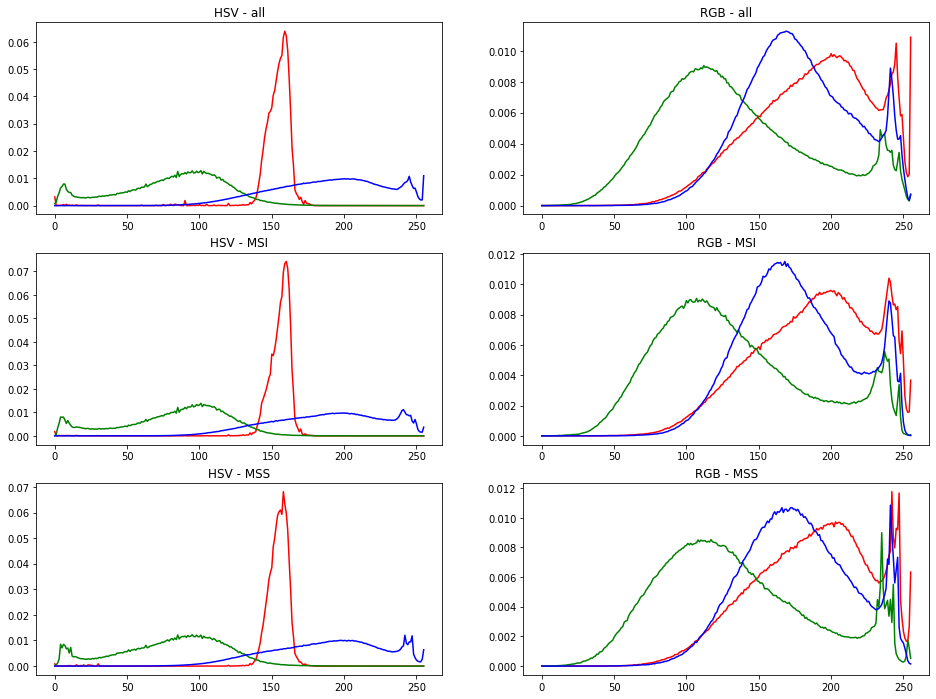

In [18]:
plt.figure(figsize=(16, 12))

ds_hsv = PatchDataset('./../dataset_ds', transform=rgb2hsv())
plt.subplot(321)
patch_stat(ds_hsv)
plt.title("HSV - all")

ds_hsv.set_filter(lb="MSI")
plt.subplot(323)
patch_stat(ds_hsv)
plt.title("HSV - MSI")
ds_hsv.reset_filter()

ds_hsv.set_filter(lb="MSS")
plt.subplot(325)
patch_stat(ds_hsv)
plt.title("HSV - MSS")


ds_rgb = PatchDataset('./../dataset_ds')
plt.subplot(322)
patch_stat(ds_rgb)
plt.title("RGB - all")

ds_rgb.set_filter(lb="MSI")
plt.subplot(324)
patch_stat(ds_rgb)
plt.title("RGB - MSI")
ds_rgb.reset_filter()

ds_rgb.set_filter(lb="MSS")
plt.subplot(326)
patch_stat(ds_rgb)
plt.title("RGB - MSS")

## Feature dimensaion reduction

In [19]:
def add_vec(mat, vec):
  print("shape mat", mat.shape)
  print("shape vec", vec.shape)
  return mat


def batch_PCA(ftrs, k=2, mean=False, eig_val=False):
  #print("Batch PCA input size: {}".format(ftrs.shape))
  ftrs = ftrs.detach().cpu().numpy()
  #ftr_var = (ftrs.T @ ftrs).cpu().numpy()
  PCA_comp = PCA(k, svd_solver='full').fit(ftrs)
  eig_vec = torch.Tensor(PCA_comp.components_)
  if mean:
    mean = np.mean(ftrs)
    eig_vec = add_vec(eig_vec, mean)
  if eig_val:
    eig_val = PCA_comp.singular_values_
    eig_vec = add_vec(eig_vec, eig_val)
  #print("Eigen Vector size :{} , with max: {}".format(eig_vec.shape, eig_vec.max()))
  return eig_vec

## Dimension reduction 

In [26]:
def patient_data(dir, nd, dr_fnc, trf=None):
  ds = PatchDataset(dir, transform=trf)
  nd = mkdir('./', nd)
  for t in ds.get_sets():
    s = mkdir(nd, t)
    for m in ds.get_labels():
     d = mkdir(s, m)
     ds.set_filter(ds=t, lb=m)
     for p, sz in ds.get_patients(num=True):
       print("Patient {} - of group {}-{} has {} patches".format(p,t,m,sz))
       ds.set_filter(ds=t, lb=m, pt=p)
       dr = dr_fnc(ds)
       fname = os.path.join(d, p + '.npy')
       with open(fname, 'wb') as f:
         np.save(f, dr)
       ds.reset_filter()
     ds.reset_filter()


def patientPCA(ds):
  bt_sz = 1
  pts = len(ds)
  if pts < 2: # Remove later
    return np.array([[2,2],[3,4]])
  for i in range(1, 64):
    if ((i % pts) == 0):
      bt_sz = i
  
  model = models.inception_v3(pretrained=True)
  model.fc = nn.Sequential(nn.Linear(2048,100), nn.Linear(100,2))
  #weights = torch.load('./model_hist_eq_0.pt', map_location=torch.device('cpu'))
  #model.load_state_dict(weights['model_state'])
  model.to(get_device())
  model.eval()
  dl = torch.utils.data.DataLoader(ds, batch_size=bt_sz, shuffle=False)
  ftrs = None
  with torch.no_grad():
    for data in dl:
      imgs = data[0].to(get_device())
      ftr = model(imgs)
      ftrs = torch.vstack((ftrs, ftr)) if ftrs is not None else ftr
  return batch_PCA(ftrs, k=2, mean=False, eig_val=False)


def read_mtx(path):
  with open(path, 'rb') as f:
    return np.load(f)

In [27]:
%rm -fr ../test_dim_red
trf = transforms.Compose([transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
patient_data('./../dataset_ds', './../test_dim_red', patientPCA, trf=trf)

found 4000
Patient CK-4951 - of group test-MSI has 21 patches
Patient AD-6964 - of group test-MSI has 28 patches
Patient CM-4743 - of group test-MSI has 168 patches
Patient AZ-6601 - of group test-MSI has 56 patches
Patient CK-6746 - of group test-MSI has 71 patches
Patient CK-6747 - of group test-MSI has 69 patches
Patient AA-3950 - of group test-MSI has 23 patches
Patient AZ-4615 - of group test-MSI has 68 patches
Patient D5-6530 - of group test-MSI has 100 patches
Patient A6-2686 - of group test-MSI has 26 patches
Patient AG-A02N - of group test-MSI has 20 patches
Patient D5-6540 - of group test-MSI has 19 patches
Patient DC-6154 - of group test-MSI has 41 patches
Patient AD-A5EJ - of group test-MSI has 23 patches
Patient AY-6197 - of group test-MSI has 70 patches
Patient G4-6302 - of group test-MSI has 15 patches
Patient G4-6586 - of group test-MSI has 24 patches
Patient G4-6309 - of group test-MSI has 8 patches
Patient G4-6588 - of group test-MSI has 14 patches
Patient AZ-6598 - o

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


Patient A6-6142 - of group train-MSS has 2 patches


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


# ML Part

In [ ]:
class AutoEncoder(nn.Module):

  def __init__(self, head, rest):
    super(AutoEncoder, self).__init__()
    self.encode = head
    self.decode = rest
  
  def forward(self, imgs):
    x = self.encode(imgs)
    return self.decode(x)

  def feature_ext(self, imgs):
    return self.encode(imgs)

In [ ]:
class vgg16_features(nn.Module):
  def __init__(self):
    super(vgg16_features, self).__init__()
    self.m = torchvision.models.vgg16(pretrained=True)

  def forward(self, imgs):
    ftrs = self.m.features(imgs)
    return torch.max(ftrs, dim=1).values
    

In [28]:
class MLPmodel(nn.Module):
  def __init__(self, input):
    super(MLPmodel, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, input//8),
        nn.ReLU(inplace=True),
        nn.Linear(input//8, 2), 
        nn.Softmax(dim=0))

    
  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    return self.mlp(ev_)


class LinearReg(nn.Module):
  def __init__(self, input):
    super(LinearReg, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, 2, bias=True),
        nn.Softmax())

  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    ev_ = self.mlp(ev_)

    return ev_



def calculate_accuracy(model, dataloader, criterion, device):
    """Used on a set model to gain loss and accuracy, does not train"""
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    total_loss = 0
    with torch.no_grad():
        for data in dataloader: # Batch wise check
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Run the images through the net
            _, predicted = torch.max(outputs.data, 1) # Top  result
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).data.item() / len(dataloader)

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, total_loss


def train(hp):
  
  model = hp["model"].to(get_device())
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= hp['lr'])
  ds_train, ds_test = hp['dataset']
  ld_train = torch.utils.data.DataLoader(ds_train, batch_size=hp['bts'], shuffle=True)
  ld_test = torch.utils.data.DataLoader(ds_test, batch_size=hp['bts'], shuffle=True)
  device = get_device()

    # training loop
  train_error = []
  test_error = []
  for epoch in range(1, hp['epochs'] + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(ld_train, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # Add statistics
          train_error.append(loss.data.item())
          running_loss += loss.data.item()

      # Advance in learning rate schedule
      # Normalizing the loss by the total number of train batches
      running_loss /= len(ld_train)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _= calculate_accuracy(model, ld_train, criterion, device)
      test_accuracy, test_loss = calculate_accuracy(model, ld_test, criterion, device)
      test_error.append(test_loss)
      log = "Epoch: {:2d} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      #train_error.append(running_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
    
  print('==> Finished Training ...')

  # Graph test and train loss across iterations
  batches = len(ld_train)
  itr = list(range(hp['epochs'] * batches))
  plt.plot(itr, train_error, 'r--', label='Train batch loss', linewidth=0.5)
  itr = list(range(batches,(hp['epochs'] * len(ld_train)+batches), batches))
  plt.plot(itr, test_error, color='g', label='Test Epoch loss', linewidth= 3)
  plt.title('Loss')
  plt.xlabel('Batch')
  plt.ylim(0, max(train_error))
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # save model
  print('==> Saving model ...')
  state = {
      'net': model.state_dict(),
      'epoch': epoch,
  }
  if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
  torch.save(state, './checkpoints/' + hp['name'] +'.pth')
   

# Run Networks

In [29]:
#def preprocess(dir, dir_new):
#  model = vgg16_features()
#  model.eval()
#  #model.features()
#  transform = get_transform(dir)
#  dataset = torchvision.datasets.DatasetFolder(root=dir, loader=torchvision.io.read_image, extensions='.png', transform=transform)
#  batch_aug(dataset, dir_new, get_class, batch_PCA, model)

def process(dir_train, dir_test , model, name):
  transform = transforms.Compose([transforms.ToTensor()])
  dataset = []
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_train, loader=read_mtx, extensions='.npy', transform=transform))
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_test, loader=read_mtx, extensions='.npy', transform=transform))

  hyper_parameters = {
      'model': model,
      'lr': 1e-3,
      'bts': 2,
      'dataset': dataset,
      'epochs': 12,
      'name': name
  }
  train(hyper_parameters)

In [30]:
process('../test_dim_red', '../test_dim_red', LinearReg(4), "LR_test")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


RuntimeError: ignored

# Grave yard

In [ ]:
class patches_DataSet(torchvision.datasets.DatasetFolder):
  def __init__(root='./data'):
    super(torchvision.datasets.DatasetFolder, seld).init__(root=root, loader=torchvision.io.read_image, extensions='.png')

  def find_classes(dir):
    return None

In [ ]:
def get_class(ds, dir):
  cls = ds.find_classes(dir)[0]
  ret = []
  for c in cls:
    case = c[-1]
    ret.append(case)
  return ret